# Concolutional Neural Network

## Importation librairies

In [1]:
import numpy as np

from tensorflow.keras.utils import normalize, plot_model
from tensorflow.keras.layers import Input, Conv1D, Activation, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import models, callbacks

import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

2024-06-04 21:50:15.368502: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 21:50:15.437678: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 21:50:15.792023: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 21:50:15.792081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 21:50:15.869063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Data import and display

health: -1.0
[ 0.50205548  0.54216265  0.72238348  1.4288852   2.1365158   2.281149
  1.9362737   1.46889     1.0088451   0.38028224 -0.29677967 -0.51392868
 -0.25564469 -0.10720254 -0.28782655 -0.41800901 -0.31916313 -0.2603787
 -0.35035721 -0.50548599 -0.71088709 -0.82391982 -0.89970154 -1.1539497
 -1.2298306  -1.044091   -1.2020312  -1.3921949  -1.1301083  -1.1798666
 -1.6492718  -1.7265754  -1.6083704  -1.6628022  -1.6506724  -1.6973094
 -1.8386968  -1.8025962  -1.7805361  -1.8251665  -1.6447633  -1.4238097
 -1.3921949  -1.3604156  -1.2001781  -0.91863234 -0.68591581 -0.66794346
 -0.51272154 -0.10169069  0.06395426  0.08261431  0.23760718  0.17479318
  0.12320539  0.5033942   0.6838702   0.47499476  0.53279711  0.72354995
  0.6644198   0.64793559  0.75705403  0.7320716   0.62021499  0.60629677
  0.67795016  0.68908363  0.59880728  0.54264656  0.58180737  0.63063068
  0.6644198   0.6863178   0.65738251  0.65088944  0.72173837  0.73970645
  0.69148052  0.69522947  0.7501145   0.85384

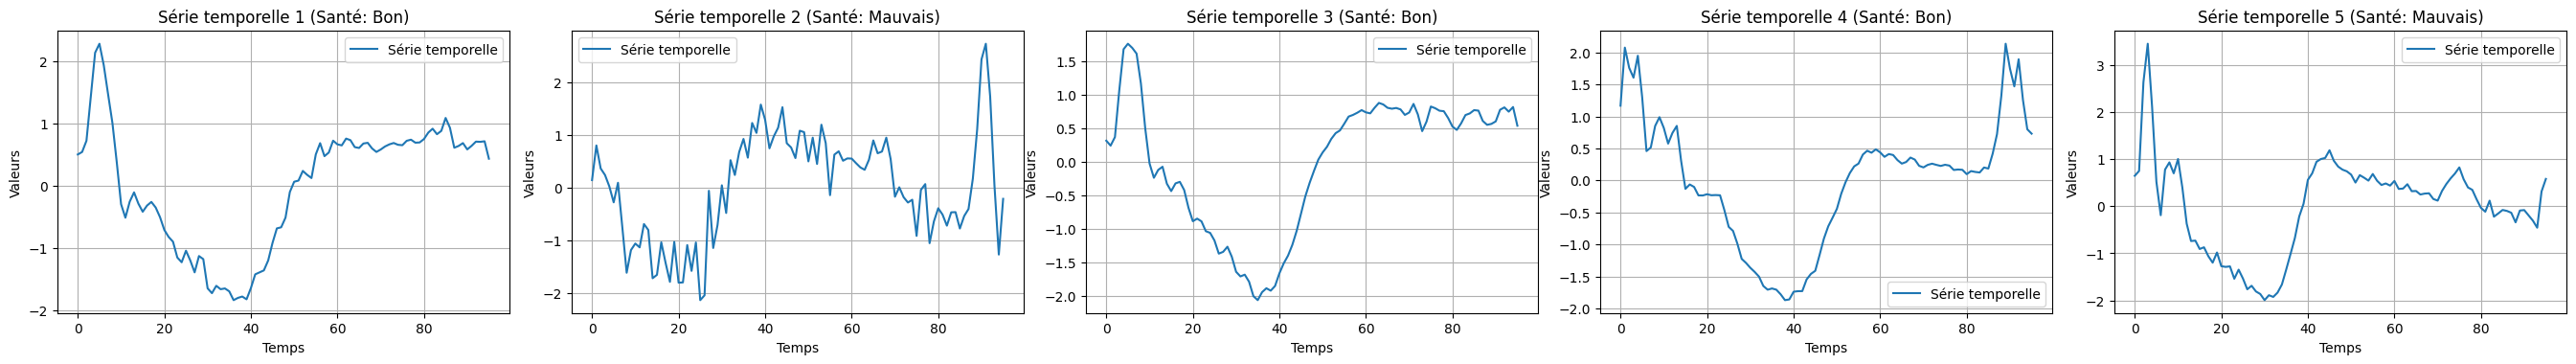

In [2]:
# Data recovery
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

# Show first time series
print("health:", train_data[0,0])
print(train_data[0,1:])

# Show data dimensions
print("Dimensions des données d'entrainnement:", train_data.shape)
print("Dimensions des données de test:", test_data.shape)

# Show first 5 time series
nb_series_a_afficher = 5
plt.figure(figsize=(27, 7))
for i in range(nb_series_a_afficher):
    serie_temporelle = train_data[i, 1:]
    etat_sante = train_data[i, 0]
    
    plage_temps = range(len(serie_temporelle))
    
    plt.subplot(2, nb_series_a_afficher, i+1)
    plt.plot(plage_temps, serie_temporelle, label='Série temporelle')
    plt.xlabel('Temps')
    plt.ylabel('Valeurs')
    plt.title(f'Série temporelle {i+1} (Santé: {"Bon" if etat_sante == -1 else "Mauvais"})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()



## Data processing

In [3]:
# Normalizer les classe
train_data[train_data[:, 0] == -1, 0] = 0
test_data[test_data[:, 0] == -1, 0] = 0

# Separation of training and testing data
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# Normalize time series between 0 and 1 independently of each other
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

# Display first data
print("health:", y_train[0])
print(X_train[0])
print("Dimensions des données d'entrainnement:", (X_train.shape, y_train.shape))


health: 0.0
[ 0.05150981  0.05562471  0.07411498  0.14660053  0.2192019   0.23404095
  0.19865749  0.15070493  0.10350532  0.03901613 -0.03044895 -0.05272797
 -0.02622859 -0.01099875 -0.02953038 -0.04288682 -0.03274545 -0.02671429
 -0.03594589 -0.05186177 -0.07293548 -0.08453239 -0.09230743 -0.11839274
 -0.12617796 -0.10712148 -0.1233258  -0.14283618 -0.11594667 -0.12105176
 -0.16921172 -0.1771429  -0.16501532 -0.17059991 -0.16935542 -0.17414027
 -0.18864631 -0.18494247 -0.18267915 -0.18725813 -0.16874915 -0.14607979
 -0.14283618 -0.1395757  -0.12313568 -0.09424969 -0.07037348 -0.06852955
 -0.05260412 -0.01043324  0.00656157  0.00847605  0.02437798  0.0179334
  0.01264061  0.05164716  0.0701636   0.04873343  0.05466383  0.07423466
  0.06816803  0.06647679  0.0776721   0.07510896  0.06363272  0.06220474
  0.06955622  0.07069849  0.06143633  0.05567436  0.05969218  0.06470134
  0.06816803  0.07041472  0.06744602  0.06677985  0.07404879  0.07589228
  0.0709444   0.07132904  0.07696012  0.

## Choice of Hyperparameters

❒ Layer hyperparameters: kernel size, dropout, method of activation of hidden layers, method of activation of the final layer, etc.

❒ The model compilation hyperparameters: optimizer, loss, learning rate, etc.

❒ Model execution hyperparameters: batch size, number of epochs, etc.

In [4]:
# Layers hyperparameters
filters = 3
kernel_size = 2
stride = 1
padding = 'same'
hidden_activation = 'relu'
final_activation = 'sigmoid' 
pool_size = 1
dropout_rate = 0.3
nb_classes = 1

# Compil hyperparameters
"""learning_rate = 0.001 # choose learning rate pour l'optimiseur adam"""                        
optimizer_algo = 'adam'
cost_function = 'binary_crossentropy'

# Execution hyperparameters
mini_batch_size = 16
nb_epochs = 1500
percentage_of_train_as_validation = 0.2

## Creating the model

In [5]:
# Input
input_shape = (96, 1)
input_layer = Input(input_shape)

# Hidden block
conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding)(input_layer)
relu_layer_1_1 = Activation(hidden_activation)(conv_layer_1_1)
conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding)(relu_layer_1_1)
relu_layer_1_2 = Activation(hidden_activation)(conv_layer_1_2)
pooling_layer_1 = MaxPooling1D(pool_size=pool_size,padding=padding)(relu_layer_1_2)
dropout_layer_1_1 = Dropout(rate=dropout_rate)(relu_layer_1_1)

# Output
flattened_layer = Flatten()(pooling_layer_1)
dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
output_layer = Dense(units=nb_classes, activation=final_activation)(dropout_flattened)

model_cnn = models.Model(inputs=input_layer, outputs=output_layer)

2024-06-04 21:50:19.521941: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Model compilation

In [6]:
model_cnn.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])

model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 96, 3)             9         
                                                                 
 activation (Activation)     (None, 96, 3)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 3)             21        
                                                                 
 activation_1 (Activation)   (None, 96, 3)             0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 96, 3)             0         
 D)                                                              
                                                             

## Model training

In [7]:
# Specify the model checkpoint (to save the best model for each epoch)
model_checkpoint = callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)

# Start training
history = model_cnn.fit(X_train, y_train,
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])


## Model evaluation

In [8]:
# Load the best validation's model
best_model_cnn = models.load_model('best_model_CNN.keras')


# Evaluate the model on train and test set
train_loss, train_accuracy = best_model_cnn.evaluate(X_train, y_train)
print(f"Test Loss: {train_loss}")
print(f"Test Accuracy: {train_accuracy}")

test_loss, test_accuracy = best_model_cnn.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 [==============================] - 0s 2ms/step - loss: 0.0951 - accuracy: 0.9700
Test Loss: 0.09511516243219376
Test Accuracy: 0.9700000286102295
4/4 [==============================] - 0s 2ms/step - loss: 0.5657 - accuracy: 0.8300
Test Loss: 0.5657348036766052
Test Accuracy: 0.8299999833106995


### Graph

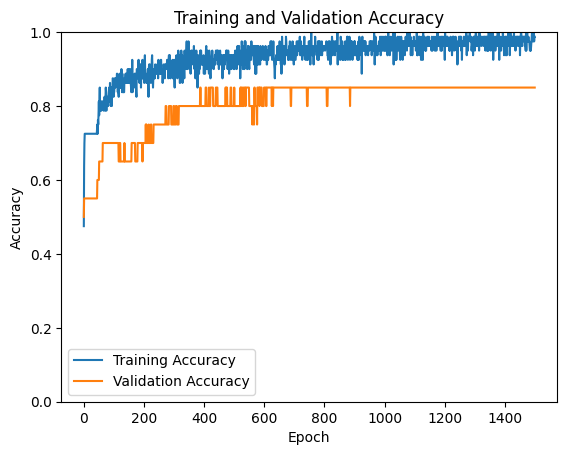

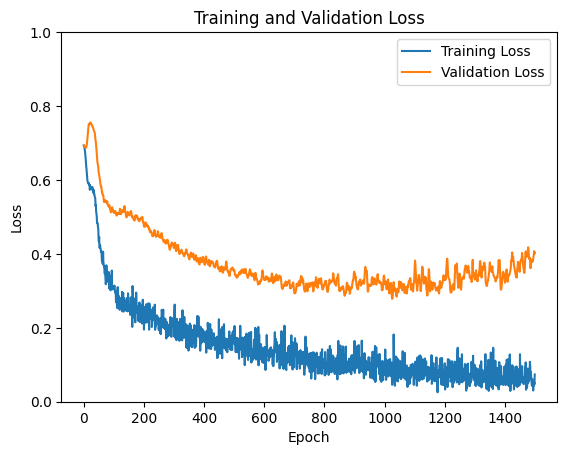

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

### Confusion matrix

4/4 [==============================] - 0s 1ms/step


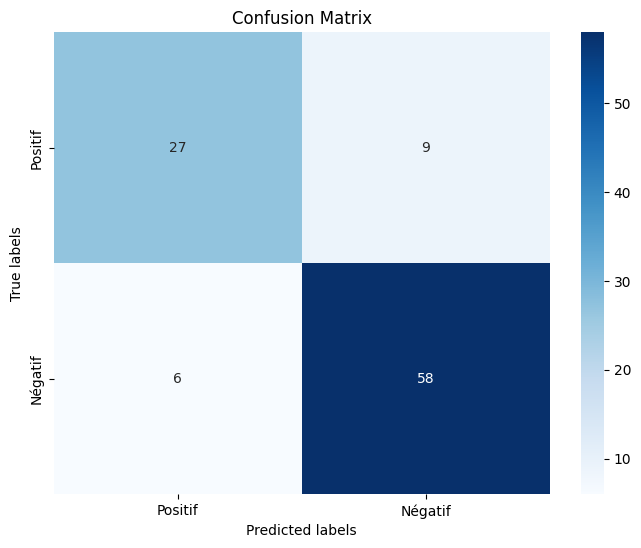

In [10]:
# Faire des prédictions sur l'ensemble de test
y_pred = model_cnn.predict(X_test)

# Convertir les probabilités de y_pred en classes binaires
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Afficher la matrice de confusion sous forme de heatmap
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_names = ['Positif', 'Négatif']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## Search for hyperparameters
by grid search and random search (to do: with cross-validation)

look hyperparameter_search_CNN


## Best result

4/4 [==============================] - 0s 2ms/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 1)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 96, 5)             15        
                                                                 
 activation_6 (Activation)   (None, 96, 5)             0         
                                                                 
 conv1d_7 (Conv1D)           (None, 96, 5)             75        
                                                                 
 activation_7 (Activation)   (None, 96, 5)             0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 48, 5)             0         
 g1D)                                                            
        

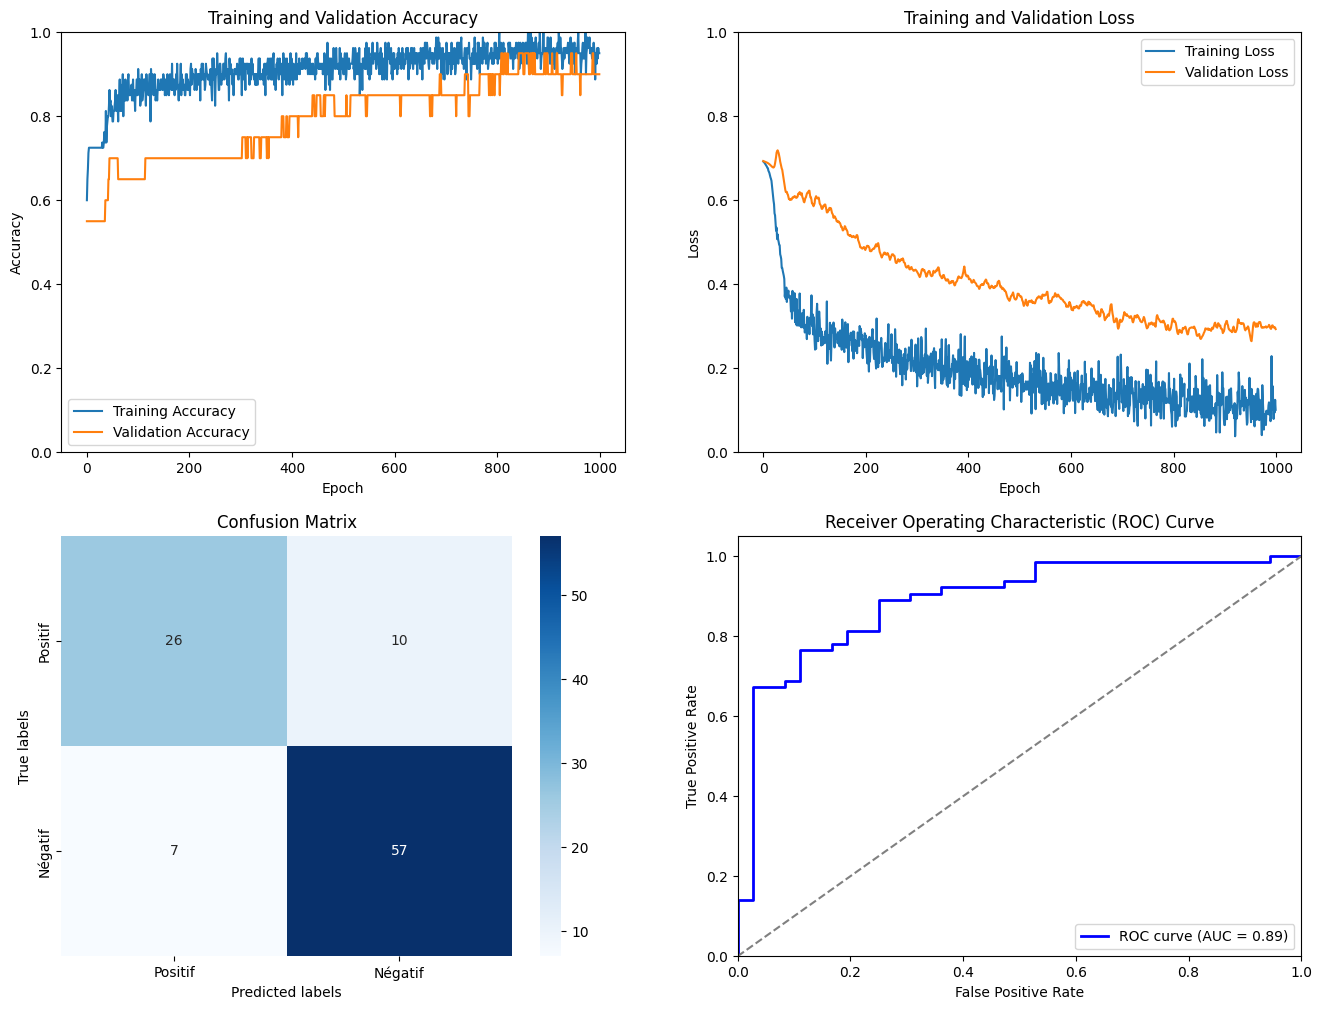

In [12]:
# Hyperparametres
filters = 5
kernel_size = 3
stride = 1
padding = 'same'
use_bias = False
hidden_activation = 'relu'
final_activation = 'sigmoid' 
pool_size = 2
dropout_rate = 0.2
nb_classes = 1
optimizer_algo = 'adam'
cost_function = 'binary_crossentropy'
mini_batch_size = 16
nb_epochs = 1000
percentage_of_train_as_validation = 0.2

# Build and compil modelt
input_shape = (96, 1)
input_layer = Input(input_shape)
conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(input_layer)
relu_layer_1_1 = Activation(hidden_activation)(conv_layer_1_1)
conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_1_1)
relu_layer_1_2 = Activation(hidden_activation)(conv_layer_1_2)
pooling_layer_1 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_1_2)
dropout_layer_1_1 = Dropout(rate=dropout_rate)(pooling_layer_1)
conv_layer_2_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(dropout_layer_1_1)
relu_layer_2_1 = Activation(hidden_activation)(conv_layer_2_1)
conv_layer_2_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_2_1)
relu_layer_2_2 = Activation(hidden_activation)(conv_layer_2_2)
pooling_layer_2 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_2_2)
flattened_layer = Flatten()(pooling_layer_2)
dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
output_layer = Dense(units=nb_classes,activation=final_activation)(dropout_flattened)
model_cnn = models.Model(inputs=input_layer, outputs=output_layer)
model_cnn.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

model_checkpoint = callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)

# Start training
start_training = time.time()
history = model_cnn.fit(X_train, y_train, 
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])
end_training = time.time()

# Evaluate best model
best_model_cnn = models.load_model('best_model_CNN.keras')
train_loss, train_accuracy = best_model_cnn.evaluate(X_train, y_train)
start_evaluate = time.time()
test_loss, test_accuracy = best_model_cnn.evaluate(X_test, y_test)
end_evaluate = time.time()

y_pred = model_cnn.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_names = ['Positif', 'Négatif']
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Result
model_cnn.summary()
plot_model(model_cnn, show_shapes=True)
training_time_seconds = end_training - start_training
evaluate_time_seconds = end_evaluate - start_evaluate
print(f"\nNombre total de paramètres : {best_model_cnn.count_params()}")
print(f"\nTemps d'entraînement : {training_time_seconds:.3f} secondes.")
print(f"Temps d'évaluation : {evaluate_time_seconds:.3f} secondes.")
print(f'\nMoyenne de train_accuracy_vals: {np.mean(train_accuracy) * 100:.2f}%')
print(f'Moyenne de train_loss_vals: {np.mean(train_loss) * 100:.2f}%')
print(f'\nMoyenne de test_accuracy_vals: {np.mean(test_accuracy) * 100:.2f}%')
print(f'Moyenne de test_loss_vals: {np.mean(test_loss) * 100:.2f}%')
print(f'\nAUC-ROC : {roc_auc * 100:.2f}%')

# Plot 
plt.figure(figsize=(16, 12))
    # Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
    # Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
    # Confusion Matrix
plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
    # ROC Curve
plt.subplot(2, 2, 4)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Cross-validation

In [ ]:
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

test_data[test_data[:, 0] == -1, 0] = 0
X_test, y_test = test_data[:, 1:], test_data[:, 0]
X_test = normalize(X_test, axis=1)

# Hyperparameters
filters = 5
kernel_size = 3
stride = 1
padding = 'same'
use_bias = False
hidden_activation = 'relu'
final_activation = 'sigmoid' 
pool_size = 2
dropout_rate = 0.2
nb_classes = 1
optimizer_algo = 'adam'
cost_function = 'binary_crossentropy'
mini_batch_size = 16
nb_epochs = 800
percentage_of_train_as_validation = 0.2

num_splits = 5
test_accuracy_vals = []
test_loss_vals = []
train_accuracy_vals = []
train_loss_vals = []

for i in range(num_splits) :
    train_data_suffled = train_data
    np.random.shuffle(train_data_suffled)
    train_data_suffled[train_data_suffled[:, 0] == -1, 0] = 0
    X_train, y_train = train_data_suffled[:, 1:], train_data_suffled[:, 0]
    X_trai = normalize(X_train, axis=1)

    # build and compil model
    input_shape = (96, 1)
    input_layer = Input(input_shape)
    conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(input_layer)
    relu_layer_1_1 = Activation(hidden_activation)(conv_layer_1_1)
    conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_1_1)
    relu_layer_1_2 = Activation(hidden_activation)(conv_layer_1_2)
    pooling_layer_1 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_1_2)
    dropout_layer_1_1 = Dropout(rate=dropout_rate)(pooling_layer_1)
    conv_layer_2_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(dropout_layer_1_1)
    relu_layer_2_1 = Activation(hidden_activation)(conv_layer_2_1)
    conv_layer_2_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_2_1)
    relu_layer_2_2 = Activation(hidden_activation)(conv_layer_2_2)
    pooling_layer_2 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_2_2)
    flattened_layer = Flatten()(pooling_layer_2)
    dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
    output_layer = Dense(units=nb_classes,activation=final_activation)(dropout_flattened)
    model_cnn = models.Model(inputs=input_layer, outputs=output_layer)
    model_cnn.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    model_checkpoint = callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)

    # start training
    history = model_cnn.fit(X_train, y_train, 
                        batch_size=mini_batch_size, 
                        epochs=nb_epochs,
                        validation_split=percentage_of_train_as_validation,
                        verbose=False,
                        callbacks=[model_checkpoint])

    # evaluate best model
    best_model_cnn = models.load_model('best_model_CNN.keras')
    train_loss, train_accuracy = best_model_cnn.evaluate(X_train, y_train)
    test_loss, test_accuracy = best_model_cnn.evaluate(X_test, y_test)

    test_accuracy_vals.append(test_accuracy)
    test_loss_vals.append(test_loss)
    train_accuracy_vals.append(train_accuracy)
    train_loss_vals.append(train_loss)

# Display result
print("\nNombre d'essais :", num_splits)
print(f'\nMoyenne de train_accuracy_vals: {np.mean(train_accuracy_vals) * 100:.2f}%')
print(f'Moyenne de train_loss_vals: {np.mean(train_loss_vals) * 100:.2f}%')
print(f'\nMoyenne de test_accuracy_vals: {np.mean(test_accuracy_vals) * 100:.2f}%')
print(f'Moyenne de test_loss_vals: {np.mean(test_loss_vals) * 100:.2f}%')
print(f'\tLa variance associée de l\'accuracy: {np.var(test_accuracy_vals):.6f}')
print(f'\tLa variance associée de la loss: {np.var(test_loss_vals):.6f}')